##MUSIC GENRE CLASSIFIER

This notebook is for using the music genre classifier model, trained on GTzan dataset , using flattened Mel-Spectogram for training the model with CNN.

Just run the notebook and upload your audio file for top 3 guesses.

In [1]:
#importing required libraries
!pip install librosa
!pip install scikit-learn
!pip install matplotlib

Model loaded from /gztan_melspectro.keras
Please upload an MP3 file (up to 30 seconds).


Saving 03TakeFive.mp3 to 03TakeFive (8).mp3

Uploaded: 03TakeFive (8).mp3
Analyzing audio...


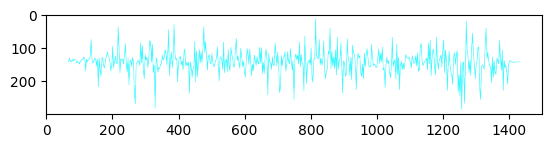


Predictions using gztan_melspectro.keras:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
# jazz: 0.3381
# metal: 0.1717
# classical: 0.1422

Cleaned up: /tmp/03TakeFive (8).mp3


In [ ]:
#Required Libraries
import numpy as np
import os
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.colab import files
import io

#Constants
SR = 22050
SLICE_SEC = 4
SLICE_LEN = SR * SLICE_SEC
N_MELS = 64
GENRE_LABELS = [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

#Load the MelSpectrogram Model
melspectro_model_path = '/gtzan_melspectro.keras'

if os.path.exists(melspectro_model_path):
    melspectro_model = load_model(melspectro_model_path)
    print(f"Model loaded from {melspectro_model_path}")
else:
    print(f"Model not found at {melspectro_model_path}")
    melspectro_model = None

#Label Encoder Setup
le = LabelEncoder()
le.fit(GENRE_LABELS)

#Prediction Function
def predict_genre_top_k(audio_path, model, label_encoder, k=3):
    clips = []
    try:
        y, sr = librosa.load(audio_path, sr=SR, duration=30)

        for i in range(6):  # 6 clips of 4s = 24s total
            start = i * SLICE_LEN
            clip = y[start:start + SLICE_LEN]
            if len(clip) == SLICE_LEN:
                clips.append(clip)

        if not clips:
            print("No full 4-second clips found. Using partial audio.")
            if len(y) > 0:
                clip = y[:SLICE_LEN]
                if len(clip) < SLICE_LEN:
                    clip = np.pad(clip, (0, SLICE_LEN - len(clip)), mode='constant')
                clips.append(clip)
            else:
                print("Error: Audio is empty or invalid.")
                return []

    except Exception as e:
        print(f"Error loading audio: {e}")
        return []

    def clips_to_mel_predict(clips, sr=SR, n_mels=N_MELS):
        mel_list = []
        for c in clips:
            m = librosa.feature.melspectrogram(y=c, sr=sr, n_mels=n_mels)
            m_db = librosa.power_to_db(m, ref=np.max)
            mel_list.append(m_db)
        X = np.array(mel_list)[..., np.newaxis]  # shape: (n_clips, 64, t, 1) (imp)
        return X

    X_clips = clips_to_mel_predict(clips)
    X_clips_norm = np.array([
        (x - np.mean(x)) / (np.std(x) + 1e-8)
        for x in X_clips
    ])

    predictions_per_clip = model.predict(X_clips_norm)
    averaged_prediction = np.mean(predictions_per_clip, axis=0)

    top_k_indices = np.argsort(averaged_prediction)[::-1][:k]
    top_k_genres = label_encoder.inverse_transform(top_k_indices)
    top_k_probs = averaged_prediction[top_k_indices]

    return list(zip(top_k_genres, top_k_probs))


#Upload and Predict
print("Please upload an MP3 file (up to 30 seconds).")
uploaded = files.upload()

if uploaded:
    uploaded_filename = list(uploaded.keys())[0]
    print(f"\nUploaded: {uploaded_filename}")

    temp_audio_path = '/tmp/' + uploaded_filename
    with open(temp_audio_path, 'wb') as f:
        f.write(uploaded[uploaded_filename])

    print("Analyzing audio...")

    try:
        y, sr = librosa.load(temp_audio_path, sr=None)
        hop = max(1, len(y) // 500)
        y_ds = y[::hop]
        fig, ax = plt.subplots(figsize=(10, 2), dpi=150)
        ax.plot(y_ds, color='#00f7ff', linewidth=1.2, alpha=0.8)
        ax.set_axis_off()
        plt.tight_layout(pad=0)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', transparent=True)
        buf.seek(0)
        plt.close()
        plt.title = "Waveform"
        plt.imshow(plt.imread(buf))
        plt.show()
    except Exception as e:
        print(f"Waveform error: {e}")

    if melspectro_model:
        print("\nPredictions using gztan_melspectro.keras:")
        top_predictions = predict_genre_top_k(temp_audio_path, melspectro_model, le, k=3)
        if top_predictions:
            for genre, prob in top_predictions:
                print(f"# {genre}: {prob:.4f}")
        else:
            print("No predictions made.")
    else:
        print("Model not available.")

    # Cleanup
    if os.path.exists(temp_audio_path):
        os.remove(temp_audio_path)
        print(f"\nCleaned up: {temp_audio_path}")
else:
    print("No file uploaded.")